## 1. Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

In [2]:
# disabeling the eager execution
tf.disable_eager_execution()

## 2. Mounting Google drive

In [3]:
# mounting google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Hyperparameters of the Generator

In [4]:
# hyperparams
image_height = 64
image_width = 64
image_channels = 3

noise_dim = 100

In [5]:
# changing the directory to the project folder
os.chdir("/content/drive/MyDrive/Face Generation")

# Loading the model which was trained for 150 epochs
load_path = f"models/FaceGAN_EPOCH:150/FaceGan"

## 4. Building the generator

In [6]:
def generator(noise, reuse = None):
       
  """
  A 100 dimensional uniform distribution Z is projected to a small spatial extent convolutional representation with many feature maps.
  A series of four fractionally-strided convolutions (in some recent papers, these are wrongly called
  deconvolutions) then convert this high level representation into a 64 × 64 pixel image. 
  """

  with tf.variable_scope("generator_model", reuse=reuse):

    weight_init = tf.glorot_normal_initializer()

    
    # shape = (BATCH_SIZE, 16384)
    hidden_1 = tf.layers.dense(inputs = noise,
                                units = 1024*4*4,
                                kernel_initializer = weight_init,
                                use_bias = False,
                                )
    hidden_1 = tf.layers.batch_normalization(hidden_1, axis = -1)
    hidden_1 = tf.nn.relu(hidden_1)

    #shape = (BATCH_SIZE, 4, 4, 1024)
    hidden_2 = tf.reshape(hidden_1, shape = [-1, 4, 4, 1024])

    # shape = (BATCH_SIZE, 8, 8, 512)
    hidden_3 = tf.layers.conv2d_transpose(inputs = hidden_2, 
                                          filters = 512,
                                          kernel_size = 5,
                                          strides = 2,
                                          kernel_initializer = weight_init,
                                          use_bias = False,
                                          padding = "same"
                                          )
    hidden_3 = tf.layers.batch_normalization(hidden_3, axis = -1)
    hidden_3 = tf.nn.relu(hidden_3)
    
    # shape = (BATCH_SIZE, 16, 16, 256)
    hidden_4 = tf.layers.conv2d_transpose(inputs = hidden_3, 
                                          filters = 256,
                                          kernel_size = 5,
                                          strides = 2,
                                          kernel_initializer = weight_init,
                                          use_bias = False,
                                          padding = "same",
                                          )
    hidden_4 = tf.layers.batch_normalization(hidden_4, axis = -1)
    hidden_4 = tf.nn.relu(hidden_4)
     
    # shape = (BATCH_SIZE, 32, 32, 128)
    hidden_5 = tf.layers.conv2d_transpose(inputs = hidden_4, 
                                          filters = 128,
                                          kernel_size = 5,
                                          strides = 2,
                                          kernel_initializer = weight_init,
                                          use_bias = False,
                                          padding = "same",
                                          )
    hidden_5 = tf.layers.batch_normalization(hidden_5, axis = -1)
    hidden_5 = tf.nn.relu(hidden_5)

    # shape = (BATCH_SIZE, 64, 64, 3)
    op =  tf.layers.conv2d_transpose(inputs = hidden_5, 
                                      filters = 3,
                                      kernel_size = 5,
                                      strides = 2,
                                      kernel_initializer = weight_init,
                                      use_bias = False,
                                      activation = tf.nn.tanh,
                                      padding = "same",
                                      )
    return op

## 5.  The Placeholders

In [7]:
# building the network
tf.reset_default_graph()
# Noise and real data placeholder | Z = noise
z = tf.placeholder(tf.float32, shape = [None, noise_dim])
gen_sample = generator(noise = z)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:308: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is depr

## 6. Loading the trained weights into the Generator and then plotting fake generated faces

In [8]:
plot_saver = "generated_faces/fake_faces.jpg"

INFO:tensorflow:Restoring parameters from models/FaceGAN_EPOCH:150/FaceGan


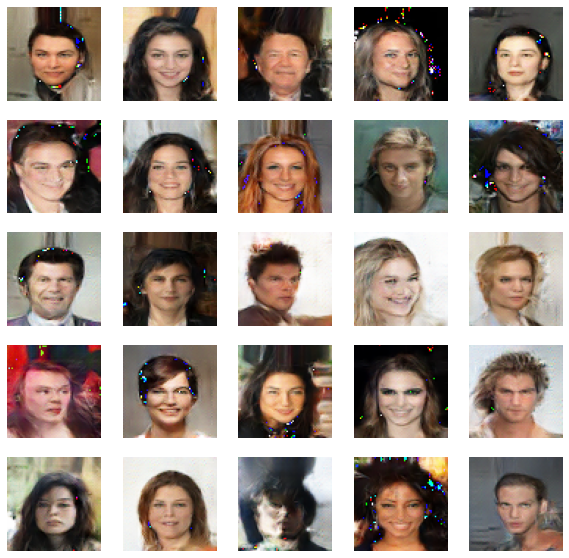

In [9]:
# generating faces 
init = tf.global_variables_initializer()
saver = tf.train.Saver()
plt.figure(figsize=(10,10)) 

with tf.Session() as sess:
  sess.run(init)
  saver.restore(sess, load_path);
  for i in range(25):
    plt.subplot(5,5,i+1)  
    noise = np.random.uniform(low = -1, high = 1, size = (1, noise_dim))
    fake_image = sess.run(gen_sample, feed_dict= {z : noise}).reshape(image_height, image_width, image_channels)
    sampled_face = (fake_image * 255).astype(np.uint8)
    plt.imshow(sampled_face.reshape(image_height, image_width, image_channels));
    plt.axis('off')
  # saving the generated fake faces
  plt.savefig(plot_saver,  bbox_inches='tight')
  plt.show()